In [70]:
import numpy as np
from PIL import Image
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Image output function
def update_image(image):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.axis('off')
    plt.show()

def to_grayscale(image):
    #array = np.asarray(image)
    #return np.round(0.3*array[:,:,0] + 0.6*array[:,:,1] + 0.11*array[:,:,2])
    return np.asarray(image.convert('L'))

In [71]:
# First image
uploaded_file = "./dog_small.png" # edit
img1 = Image.open(uploaded_file) if uploaded_file else None

# Second Image
second_uploaded_file = "./parrot_small.png" # edit
img2 = Image.open(second_uploaded_file) if second_uploaded_file else None

In [72]:
# Show loaded images
img1_plot = widgets.interactive(update_image, image = widgets.fixed(img1))
img2_plot = widgets.interactive(update_image, image = widgets.fixed(img2))
hbox = widgets.HBox([img1_plot,img2_plot])
display(hbox)

In [73]:
# Lamda parameter for interpolation between phases
parameter = widgets.FloatSlider(
    value=1.0,
    min=0.0,
    max=1.0,
    step=0.01,
    description='Lambda: ',
    continuous_update=False
)
display(parameter)

FloatSlider(value=1.0, continuous_update=False, description='Lambda: ', max=1.0, step=0.01)

In [74]:
def mix_arrays_with_fft(arr1, arr2, parameter = 1):
    """
    Interpolates between fft phases of array and applies them to the 
    second array.
    parameter = 1 => phases only from the first array
    parameter = 0 => phases only from the second array (nothing will be changed)
    Returns the second array after modification.
    """
    fouriered1 = np.fft.fft2(arr1)
    angles1 = np.angle(fouriered1)
    magnitudes1 = np.abs(fouriered1)

    fouriered2 = np.fft.fft2(arr2)
    angles2 = np.angle(fouriered2)
    magnitudes2 = np.abs(fouriered2)

    fouriered_mixed = np.zeros(fouriered2.shape, dtype=complex)
    for x in np.arange(fouriered1.shape[0]):
        for y in np.arange(fouriered1.shape[1]):
            angle = angles1[x,y]*parameter + angles2[x,y]*(1-parameter)
            #fouriered_mixed[x,y] = magnitudes2[x,y] * np.exp(1j * angle)
            fouriered_mixed[x,y] = magnitudes2[x,y] * (np.cos(angle) + np.sin(angle)*1j)

    mixed = np.fft.ifft2(fouriered_mixed)
    return abs(mixed)

def mix_images_with_fft_grayscale(img1, img2, parameter = 1):
    """
    Interpolates between fft phases of two images converted to grayscale 
    and applies them to the second image.
    parameter = 1 => phases only from the first image
    parameter = 0 => phases only from the second image (nothing will be changed)
    Returns the second image after modification.
    """
    black_and_white1 = to_grayscale(img1)
    black_and_white2 = to_grayscale(img2)   
    return mix_arrays_with_fft(black_and_white1, black_and_white2, parameter)

img1_grayscale = to_grayscale(img1)
img1_grayscale_plot = widgets.interactive(update_image, image = widgets.fixed(img1_grayscale))
img_mixed = mix_images_with_fft_grayscale(img1, img2, parameter.value)
img1_mixed_plot = widgets.interactive(update_image, image = widgets.fixed(img_mixed))

img2_grayscale = to_grayscale(img2)
img2_grayscale_plot = widgets.interactive(update_image, image = widgets.fixed(img2_grayscale))
img2_mixed = mix_images_with_fft_grayscale(img2, img1, parameter.value)
img2_mixed_plot = widgets.interactive(update_image, image = widgets.fixed(img2_mixed))

hbox = widgets.HBox([img1_plot, img2_plot])
display(hbox)
hbox = widgets.HBox([img1_grayscale_plot, img2_grayscale_plot])
display(hbox)
# Swapped to be in same order as in the paper
hbox_mixed = widgets.HBox([img2_mixed_plot,img1_mixed_plot])
display(hbox_mixed)



(np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5))

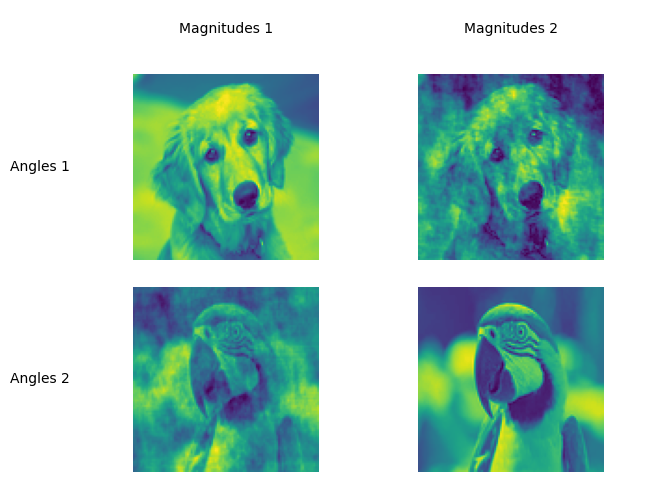

In [75]:
# Maybe a better visualization, not in the same layout as the article

row_notes = []
col_notes = ["Angles 1", "Angles 2"]

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(3, 3, width_ratios=[0.2, 1, 1], height_ratios=[0.2, 1, 1])

def textplot(text,x,y):
    ax = fig.add_subplot(gs[x, y])
    ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=10)
    ax.axis('off')
textplot("Magnitudes 1",0,1)
textplot("Magnitudes 2",0,2)
textplot("Angles 1",1,0)
textplot("Angles 2",2,0)
ax = fig.add_subplot(gs[1, 1])
ax.imshow(img1_grayscale)
ax.axis('off')
ax = fig.add_subplot(gs[2, 2])
ax.imshow(img2_grayscale)
ax.axis('off')
ax = fig.add_subplot(gs[1, 2])
ax.imshow(img_mixed)
ax.axis('off')
ax = fig.add_subplot(gs[2, 1])
ax.imshow(img2_mixed)
ax.axis('off')


In [76]:
# 
def mix_images_with_fft_rgb(img1, img2, parameter = 1):
    """
    Interpolates between fft phases of two images in red, green and blue component
    and applies them to the second image.
    parameter = 1 => phases only from the first image
    parameter = 0 => phases only from the second image (nothing will be changed)
    Returns the second image after modification.
    """
    array1 = np.asarray(img1)
    array2 = np.asarray(img2)
    
    r_mixed = mix_arrays_with_fft(array1[:,:,0], array2[:,:,0], parameter)
    g_mixed = mix_arrays_with_fft(array1[:,:,1], array2[:,:,1], parameter)
    b_mixed = mix_arrays_with_fft(array1[:,:,2], array2[:,:,2], parameter)
    return Image.fromarray(np.uint8(np.stack([r_mixed, g_mixed, b_mixed], axis=2)))


img1_mixed_rgb = mix_images_with_fft_rgb(img1, img2, parameter.value)
img1_mixed_rgb_plot = widgets.interactive(update_image, image = widgets.fixed(img1_mixed_rgb))


img2_mixed_rgb = mix_images_with_fft_rgb(img2, img1, parameter.value)
img2_mixed_rgb_plot = widgets.interactive(update_image, image = widgets.fixed(img2_mixed_rgb))

hbox = widgets.HBox([img1_plot, img2_plot])
display(hbox)
# Swapped to be in same order as in the paper
hbox_mixed = widgets.HBox([img2_mixed_rgb_plot,img1_mixed_rgb_plot])
display(hbox_mixed)



(np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5))

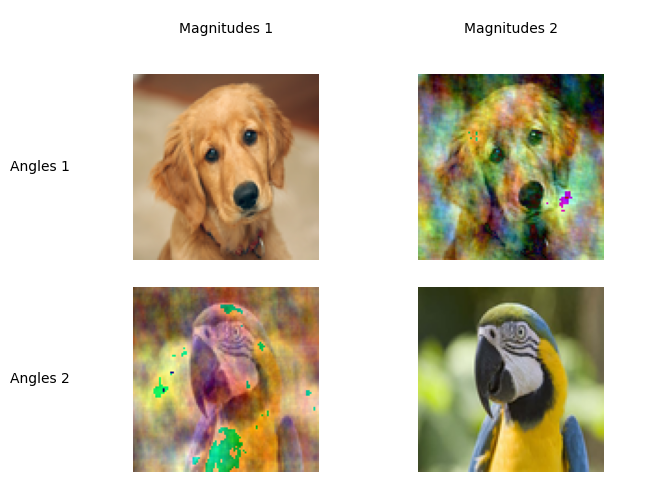

In [77]:
# Maybe a better visualization, not in the same layout as the article

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(3, 3, width_ratios=[0.2, 1, 1], height_ratios=[0.2, 1, 1])

def textplot(text,x,y):
    ax = fig.add_subplot(gs[x, y])
    ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=10)
    ax.axis('off')
textplot("Magnitudes 1",0,1)
textplot("Magnitudes 2",0,2)
textplot("Angles 1",1,0)
textplot("Angles 2",2,0)
ax = fig.add_subplot(gs[1, 1])
ax.imshow(img1)
ax.axis('off')
ax = fig.add_subplot(gs[2, 2])
ax.imshow(img2)
ax.axis('off')
ax = fig.add_subplot(gs[1, 2])
ax.imshow(img1_mixed_rgb)
ax.axis('off')
ax = fig.add_subplot(gs[2, 1])
ax.imshow(img2_mixed_rgb)
ax.axis('off')
